In [1]:
import torch

import os
os.environ["LFI_PROJECT_DIR"] = '/home/ge57buc/code/lfi_mackelab/'

import sbi.inference as inference
import sbi.simulators as simulators
import sbi.utils as utils

from matplotlib import pyplot as plt

# use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type("torch.FloatTensor")

# get simulator and prior
simulator, prior = simulators.get_simulator_and_prior("nonlinear-gaussian")

prior = torch.distributions.MultivariateNormal(loc=torch.zeros(5), 
                                               precision_matrix=0.1*torch.eye(5))

# get neural posterior (here a MAF)
neural_posterior = utils.get_neural_posterior(
    "mdn-1",
    parameter_dim=simulator.parameter_dim,
    observation_dim=simulator.observation_dim,
    simulator=simulator,
)

# create inference method
inference_method = inference.CDELFI(
    simulator=simulator,
    prior=prior,
    true_observation=simulator.get_ground_truth_observation(),
    neural_posterior=neural_posterior,
)

# run inference
inference_method.run_inference(num_rounds=3, num_simulations_per_round=5000, num_components=8)


/home/ge57buc/code/pyknos/pyknos/transforms/standard.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_shift", torch.tensor(shift if (shift is not None) else 0.0)
/home/ge57buc/code/pyknos/pyknos/transforms/standard.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_scale", torch.tensor(scale if (scale is not None) else 1.0)
-------------------------49<01:39, 49.88s/it]
||||| ROUND 1 STATS |||||:
-------------------------
Epochs trained: 67
Best validation performance: -11.2121

-------------------------0:49<01:39, 49.88s/it]
||||| ROUND 1 STATS |||||:
-------------------------
Epochs trained: 67
Best validation performance: -11.2121

-------------------------2:02<00:56, 56.63s/

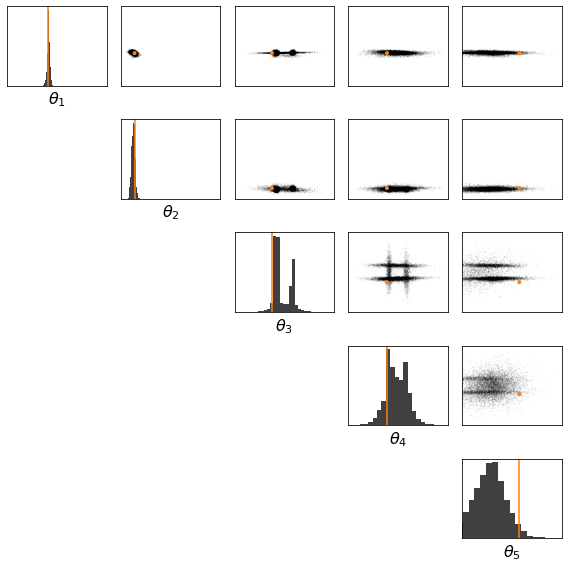

In [2]:
# plot samples from uncorrectd posterior
samples = inference_method.sample_posterior(num_samples=10000)

# sample from uncorrected posterior (i.e. directly from learned MDN)
utils.plot_hist_marginals(
    utils.tensor2numpy(samples),
    lims=simulator.parameter_plotting_limits,
    ground_truth=utils.tensor2numpy(simulator.get_ground_truth_parameters()).reshape(
        -1
    ),
)
plt.show()

pruning unused MDN components, continuing with 8 components 



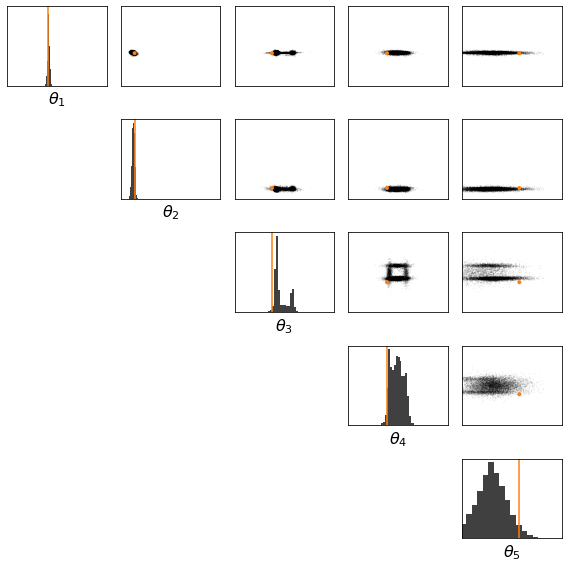

In [3]:
# plot samples from corrected posterior
import torch

# get proposal and prior variables
proposal = inference_method._model_bank[-2].get_mixture_components(inference_method._true_observation)
correction_factors = {
   'mp' : proposal[1].squeeze().clone().detach(),
   'Pp' : proposal[2].squeeze().clone().detach()                   
}
if isinstance(inference_method._prior, torch.distributions.MultivariateNormal):                    
    correction_factors['m0'] = inference_method._prior.loc 
    correction_factors['P0'] = inference_method._prior.precision_matrix
elif isinstance(inference_method._prior, distributions.Uniform):                     
    correction_factors['m0'] = (inference_method._prior.high-inference_method._prior.low)/2.
    correction_factors['P0'] = 0. * torch.eye(inference_method._prior.low.shape[0])

# sample from corrected posterior
samples = inference_method.sample_posterior(num_samples=10000, correction_factors=correction_factors)

utils.plot_hist_marginals(
    utils.tensor2numpy(samples),
    lims=simulator.parameter_plotting_limits,
    ground_truth=utils.tensor2numpy(simulator.get_ground_truth_parameters()).reshape(
        -1
    ),
)
plt.show()